Stakeholder: PRAMS Pregnancy Monitoring Network

Business Problem: APGAR Score is a metric doctors use to measure the overall health of a newborn infant. But what if there were a way to prepare for a low APGAR score before the infant is even born? PRAMS has asked me to use natality data to create a model to alert medical staff if a newborn is likely to need emergency medical intervention.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xlrd
import os
import seaborn as sns
import xgboost
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier,\
ExtraTreesClassifier, VotingClassifier, StackingRegressor
from sklearn.metrics import r2_score, accuracy_score, precision_score
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier

In [3]:
# Read in the data sets
df = pd.read_csv("data/nat2019us.csv")

C:\Users\Patrick\anaconda3\envs\learn-env\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (23) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [4]:
df.columns

Index(['dob_yy', 'dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'f_facility',
       'bfacil3', 'mage_impflg', 'mage_repflg', 'mager',
       ...
       'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom', 'f_ca_hypos',
       'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object', length=226)

In [5]:
df.columns[23]

'mar_p'

In [6]:
df['mm_aicu'].value_counts()

N    3746724
Y       6745
U       4113
Name: mm_aicu, dtype: int64

In [7]:
df['apgar5r'].value_counts()

4    3170200
3     495375
2      55585
1      21749
5      14673
Name: apgar5r, dtype: int64

In [8]:
df.head()

,dob_yy,dob_mm,dob_tt,dob_wk,bfacil,f_facility,bfacil3,mage_impflg,mage_repflg,mager,...,f_ca_cleftlp,f_ca_cleft,f_ca_downs,f_ca_chrom,f_ca_hypos,no_congen,itran,ilive,bfed,f_bfed
0,2019,1,1135,3,1,1,1,NaN,NaN,29,...,1,1,1,1,1,1,N,Y,Y,1
1,2019,1,1305,3,1,1,1,NaN,NaN,40,...,1,1,1,1,1,1,N,Y,Y,1
2,2019,1,800,3,1,1,1,NaN,NaN,30,...,1,1,1,1,1,1,N,Y,Y,1
3,2019,1,130,4,1,1,1,NaN,NaN,25,...,1,1,1,1,1,1,N,Y,Y,1
4,2019,1,1426,4,1,1,1,NaN,NaN,38,...,1,1,1,1,1,1,N,Y,Y,1


In [9]:
df.columns[215:]

Index(['f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 'f_ca_chrom',
       'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed'],
      dtype='object')

In [11]:
remove = ['dob_yy', 'f_facility', 'bfacil3', 'mage_impflg', 'mage_repflg', 'mager14', 'mager9', 'mrace31', 'mrace6', 'mrace15',
           'mraceimp', 'mhispx', 'f_mhisp', 'mracehisp', 'mar_p', 'mar_imp', 'f_mar_p', 'f_meduc', 'fagerpt_flg', 'fagerec11',
           'frace31', 'frace15', 'fhispx', 'f_fhisp', 'lbo_rec', 'tbo_rec', 'illb_r', 'illb_r11', 'ilop_r',
           'ilop_r11', 'ilp_r11', 'f_mpcb', 'precare5', 'previs_rec', 'f_tpcv', 'f_wic', 'cig0_r', 'cig1_r', 'cig2_r',
           'cig3_r', 'f_cigs_0', 'f_cigs_1', 'f_cigs_2', 'f_cigs_3', 'cig_rec', 'f_tobaco', 'f_m_ht', 'bmi_r', 'pwgt_r',
           'f_pwgt', 'f_dwgt', 'wtgain_rec', 'f_wtgain', 'f_rf_pdiab', 'f_rf_gdiab', 'f_rf_phyper', 'f_rf_ghyper', 
           'f_rf_eclamp', 'f_rf_ppb', 'f_rf_inf_drg', 'f_rf_inf_art', 'rf_cesar', 'f_rf_cesar', 'f_rf_ncesar',
           'no_risks', 'f_ip_gonor', 'f_ip_syph', 'f_ip_chlam', 'f_ip_hepatb', 'f_ip_hepatc', 'no_infec', 'ob_ecvs', 'ob_ecvf',
           'f_ob_succ', 'f_ob_fail', 'ld_indl', 'ld_augm', 'ld_anes', 'f_ld_indl', 'f_ld_augm', 'f_ld_ster', 'f_ld_antb',
           'f_ld_chor', 'f_ld_anes', 'no_lbrdlv', 'me_pres', 'me_rout', 'me_trial', 'f_me_pres', 'f_me_rout', 'f_me_trial',
           'rdmeth_rec', 'dmeth_rec', 'f_dmeth_rec', 'mm_mtr', 'mm_plac', 'mm_rupt', 'mm_uhyst', 'mm_aicu', 'f_mm_mtr',
           'f_mm_rupt', 'f_mm_uhyst', 'f_mm_aicu', 'no_mmorb', 'mtran', 'pay', 'f_pay', 'f_pay_rec', 'apgar5r',
           'f_apgar5', 'apgar10', 'apgar10r', 'imp_plur', 'setorder_r', 'imp_sex', 'dlmp_mm', 'dlmp_yy', 'compgst_imp',
           'obgest_flg', 'gestrec10', 'gestrec3', 'lmpused', 'oegest_comb', 'oegest_r10', 'dbwt', 'bwtr12', 'bwtr4',
           'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'f_ab_vent', 'f_ab_vent6',
           'f_ab_surfac', 'f_ab_antibio', 'f_ab_seiz', 'no_abnorm', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 
           'ca_gast', 'f_ca_anen', 'f_ca_menin', 'f_ca_heart', 'f_ca_hernia', 'f_ca_ompha', 'f_ca_gastro', 'ca_limb',
           'ca_cleft', 'ca_clpal', 'ca_disor', 'ca_hypo', 'f_ca_limb', 'f_ca_cleftlp', 'f_ca_cleft', 'f_ca_downs', 
           'f_ca_chrom', 'f_ca_hypos', 'no_congen', 'itran', 'ilive', 'bfed', 'f_bfed', 'f_mm_', 'f_ab_nicu', 'fracehisp',
           'oegest_r3']

In [12]:
df.drop(remove, axis=1, inplace=True)
df.columns

Index(['dob_mm', 'dob_tt', 'dob_wk', 'bfacil', 'mager', 'mbstate_rec',
       'restatus', 'mbrace', 'mhisp_r', 'dmar', 'meduc', 'fagecomb', 'frace6',
       'fhisp_r', 'feduc', 'priorlive', 'priordead', 'priorterm', 'ilp_r',
       'precare', 'previs', 'wic', 'cig_0', 'cig_1', 'cig_2', 'cig_3',
       'm_ht_in', 'bmi', 'dwgt_r', 'wtgain', 'rf_pdiab', 'rf_gdiab',
       'rf_phype', 'rf_ghype', 'rf_ehype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg',
       'rf_artec', 'rf_cesarn', 'ip_gon', 'ip_syph', 'ip_chlam', 'ip_hepatb',
       'ip_hepatc', 'ld_ster', 'ld_antb', 'ld_chor', 'attend', 'pay_rec',
       'apgar5', 'dplural', 'sex', 'combgest', 'ca_downs'],
      dtype='object')

In [13]:
rename = ['birth_month', 'birth_time', 'birth_day', 'birth_place', 'mother_age', 'mother_nativity', 'mother_residence',
          'mother_race', 'mother_hispanic', 'marital_status', 'mother_education', 'father_age', 'father_race',
          'father_hispanic', 'father_education', 'living_children', 'deceased_children', 'terminations', 
          'months_last_pregnancy', 'first_prenatal_care_month', 'prenatal_visits', 'food_assistance', 'prepregnancy_daily_cig',
          'first_tri_daily_cig', 'second_tri_daily_cig', 'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
          'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension', 'gestational_hypertension', 'eclampsia',
          'previous_premature_birth', 'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
          'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
          'chorioamnionitis', 'attendant', 'payment_method', 'apgar_score', 'plural_pregnancy', 'infant_sex', 'weeks_gestation',
          'down_syndrome']

In [14]:
df.columns = rename
len(df.columns)

Index(['birth_month', 'birth_time', 'birth_week', 'birth_place', 'mother_age',
       'mother_nativity', 'mother_residence', 'mother_race', 'mother_hispanic',
       'marital_status', 'mother_education', 'father_age', 'father_race',
       'father_hispanic', 'father_education', 'living_children',
       'deceased_children', 'terminations', 'months_last_pregnancy',
       'first_prenatal_care_month', 'prenatal_visits', 'food_assistance',
       'prepregnancy_daily_cig', 'first_tri_daily_cig', 'second_tri_daily_cig',
       'third_tri_daily_cig', 'height', 'bmi', 'delivery_weight',
       'weight_gain', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'previous_cesareans', 'gonorrhea', 'syphilis', 'chlamydia',
       'hepatitis_b', 'hepatitis_c', 'steroids', 'antibiotics',
       'chorioamnionitis', 'attendant', 'payment_method'

In [15]:
len(df.columns)

55

<AxesSubplot:>

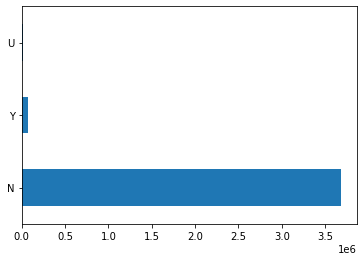

In [46]:
df['chlamydia'].value_counts().plot(kind='barh')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3757582 entries, 0 to 3757581
Data columns (total 55 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   birth_month                int64  
 1   birth_time                 int64  
 2   birth_week                 int64  
 3   birth_place                int64  
 4   mother_age                 int64  
 5   mother_nativity            int64  
 6   mother_residence           int64  
 7   mother_race                int64  
 8   mother_hispanic            int64  
 9   marital_status             float64
 10  mother_education           int64  
 11  father_age                 int64  
 12  father_race                int64  
 13  father_hispanic            int64  
 14  father_education           int64  
 15  living_children            int64  
 16  deceased_children          int64  
 17  terminations               int64  
 18  months_last_pregnancy      int64  
 19  first_prenatal_care_month  int64  
 20  pr

In [66]:
df_cat = df.select_dtypes(include=['object'])
for c in df_cat.columns:
    print("---- %s ---" % c)
    print(df[c].value_counts())

---- food_assistance ---
N    2457297
Y    1256694
U      43591
Name: food_assistance, dtype: int64
---- diabetes ---
N    3717529
Y      36603
U       3450
Name: diabetes, dtype: int64
---- gestational_diabetes ---
N    3495054
Y     259078
U       3450
Name: gestational_diabetes, dtype: int64
---- hypertension ---
N    3670933
Y      83199
U       3450
Name: hypertension, dtype: int64
---- gestational_hypertension ---
N    3462061
Y     292071
U       3450
Name: gestational_hypertension, dtype: int64
---- eclampsia ---
N    3743594
Y      10538
U       3450
Name: eclampsia, dtype: int64
---- previous_premature_birth ---
N    3617523
Y     136609
U       3450
Name: previous_premature_birth, dtype: int64
---- infertility_treatment ---
N    3677981
Y      76151
U       3450
Name: infertility_treatment, dtype: int64
---- fertility_drugs ---
X    3677981
N      43102
Y      29041
U       7458
Name: fertility_drugs, dtype: int64
---- assisted_reproduction ---
X    3677981
Y      48957
N   

In [91]:
df_cat.columns

Index(['food_assistance', 'diabetes', 'gestational_diabetes', 'hypertension',
       'gestational_hypertension', 'eclampsia', 'previous_premature_birth',
       'infertility_treatment', 'fertility_drugs', 'assisted_reproduction',
       'gonorrhea', 'syphilis', 'chlamydia', 'hepatitis_b', 'hepatitis_c',
       'steroids', 'antibiotics', 'chorioamnionitis', 'infant_sex',
       'downs_syndrome'],
      dtype='object')

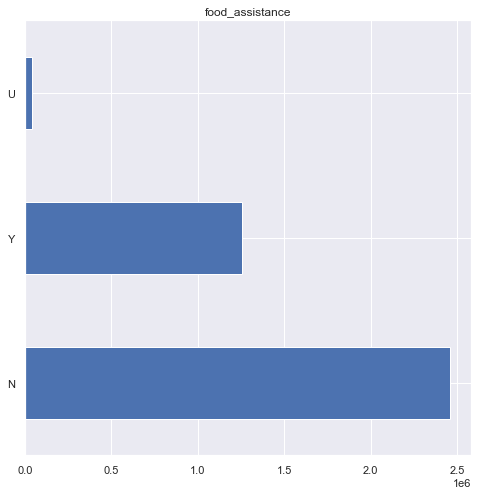

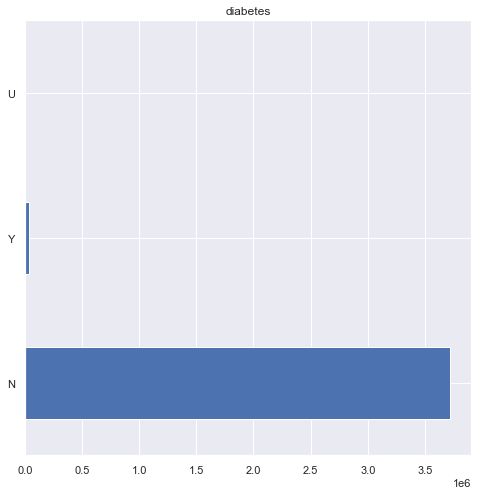

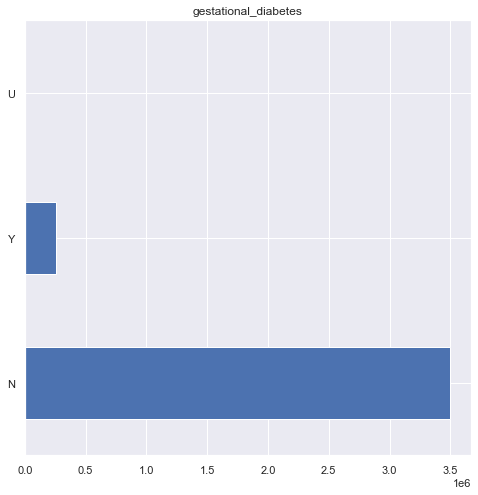

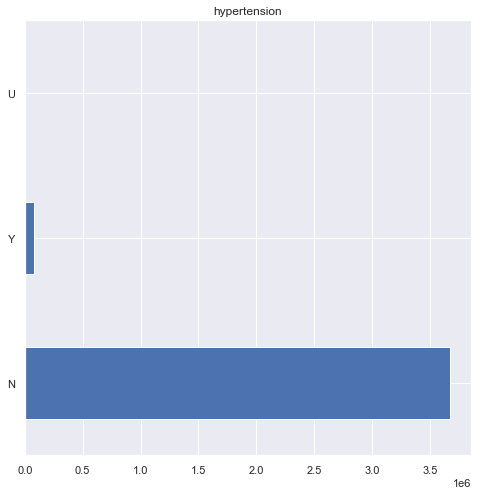

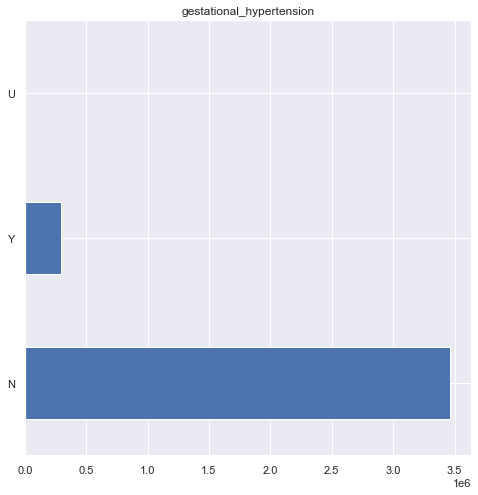

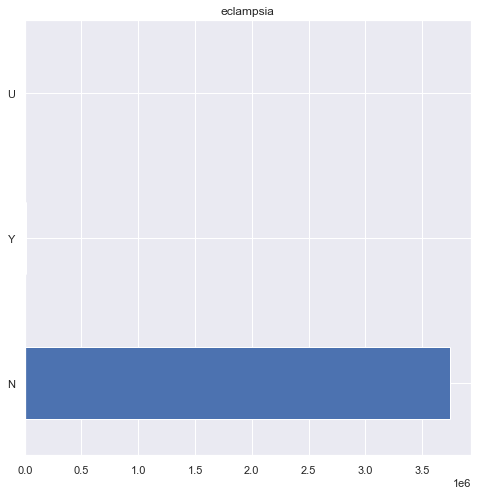

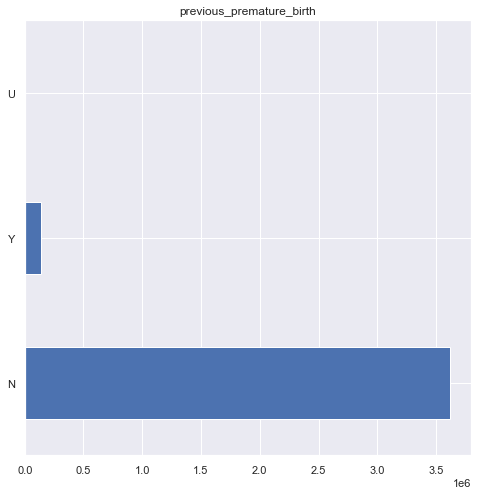

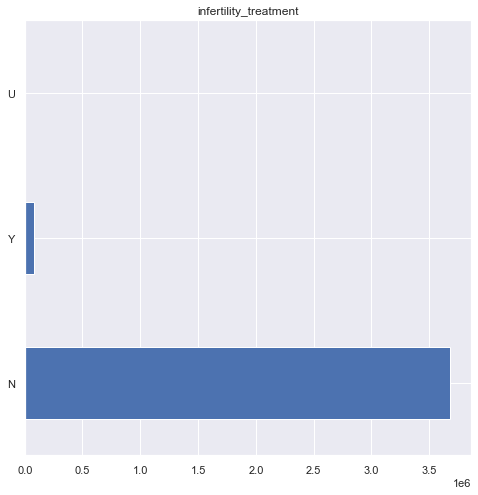

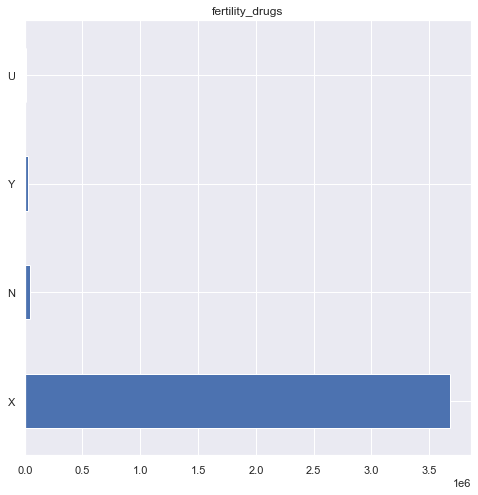

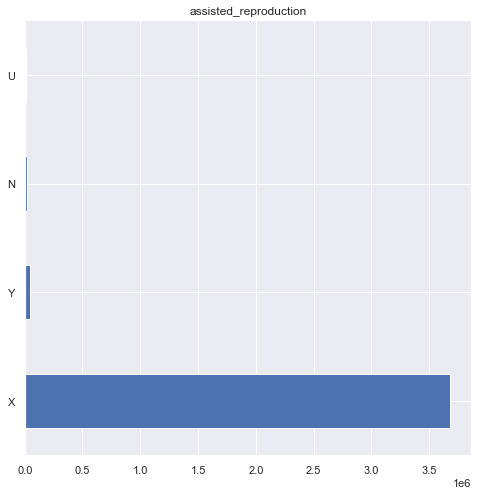

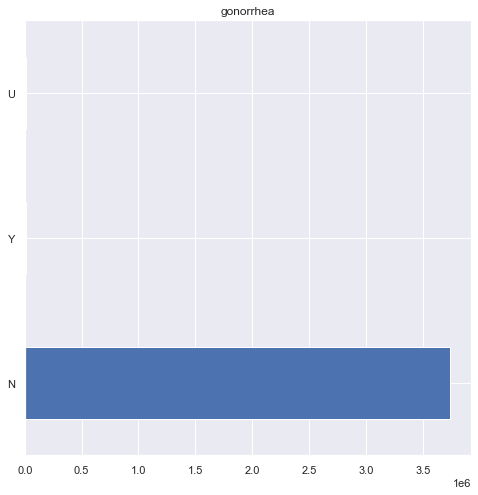

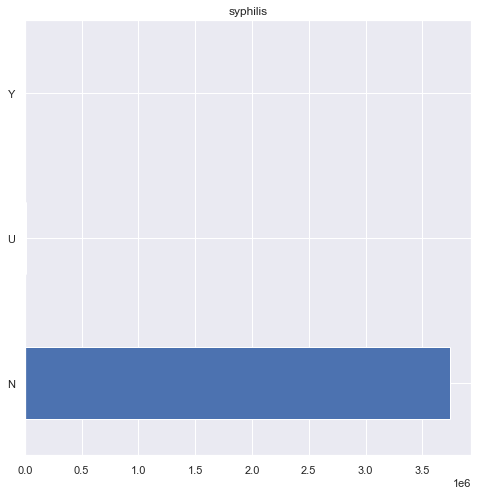

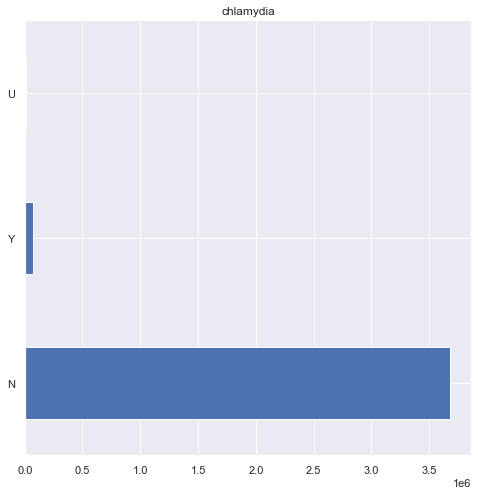

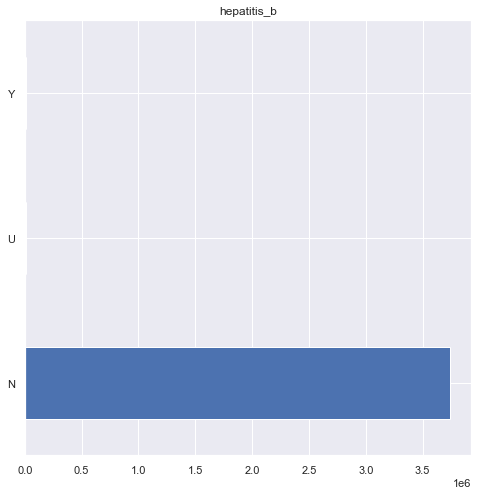

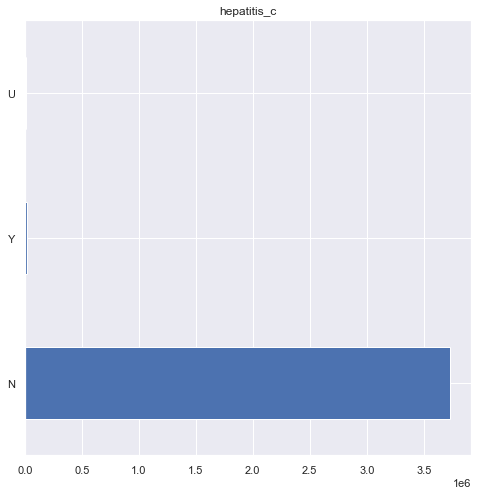

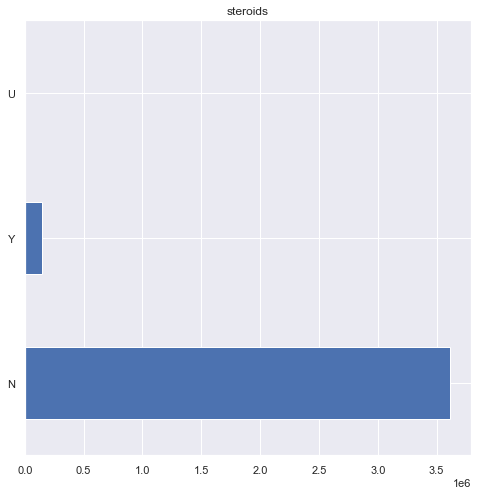

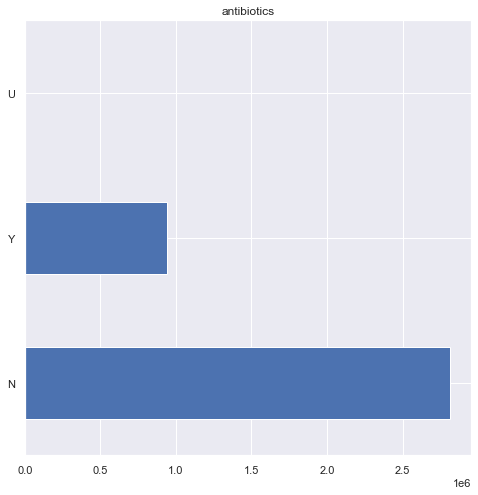

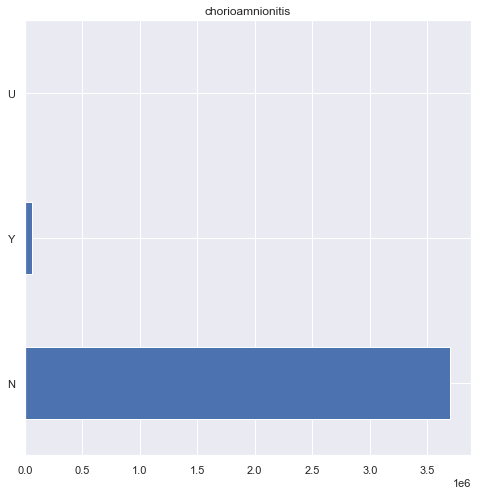

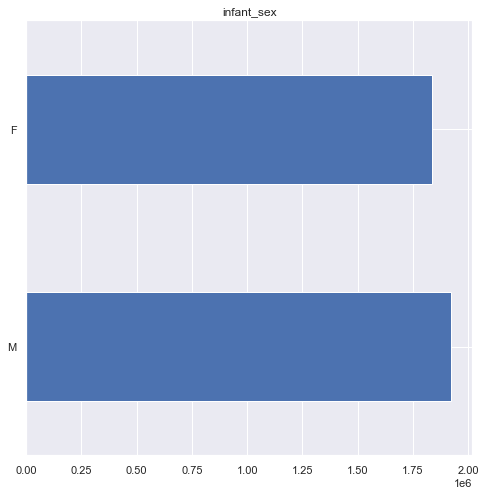

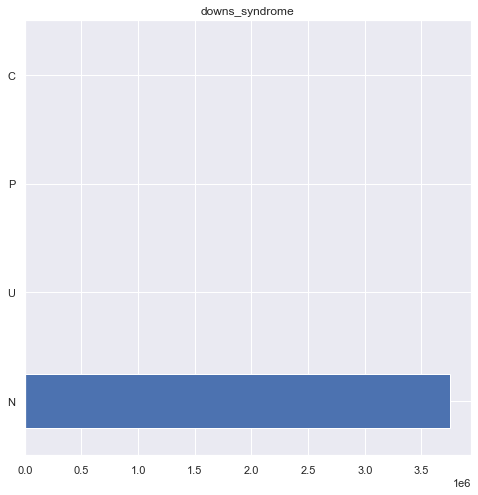

In [101]:
# fig, axis = plt.subplots(len(df_cat.columns), 2, figsize=(12,len(df_cat.columns)*2.5))
# ax1 = 

for i in df_cat.columns :
#     ax = ax[i]
    df_cat[i].value_counts().plot(kind='barh', title=i)
    plt.show()

In [ ]:
data_num = 3

x = np.random.uniform(1, 10, size=(data_num, data_num, 20))
y = np.random.uniform(5, 20, size=(data_num, data_num, 20))

fig, axes = plt.subplots(nrows=data_num, ncols=data_num, sharex=True, sharey=True)
for n in range(data_num):  #row index
    for p in range(data_num):  # column index
        # Call `scatter` or any plot function on the 
        # respective `axes` object itself
        axes[n,p].scatter(x[n,p], y[n,p])
        print(f'plotting at index [ {n} , {p}]')
plt.savefig('figure.png')


In [ ]:
cols_to_plot = df_cat.columns

fig, ax = plt.subplots(
    len(cols_to_plot), 2, figsize=(9,len(cols_to_plot)*2.5)
)
for idx, col in enumerate(cols_to_plot):
    vaccination_rate_plot(
        col, 'h1n1_vaccine', joined_df, ax=ax[idx, 0]
    )
    vaccination_rate_plot(
        col, 'seasonal_vaccine', joined_df, ax=ax[idx, 1]
    )
    
ax[0, 0].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='h1n1_vaccine'
)
ax[0, 1].legend(
    loc='lower center', bbox_to_anchor=(0.5, 1.05), title='seasonal_vaccine'
)
fig.tight_layout()

<ipython-input-57-db2104ea8bab>:2: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  df.hist(ax=axis, bins='auto')


array([[<AxesSubplot:title={'center':'birth_month'}>,
        <AxesSubplot:title={'center':'birth_time'}>,
        <AxesSubplot:title={'center':'birth_week'}>,
        <AxesSubplot:title={'center':'birth_place'}>,
        <AxesSubplot:title={'center':'mother_age'}>,
        <AxesSubplot:title={'center':'mother_nativity'}>],
       [<AxesSubplot:title={'center':'mother_residence'}>,
        <AxesSubplot:title={'center':'mother_race'}>,
        <AxesSubplot:title={'center':'mother_hispanic'}>,
        <AxesSubplot:title={'center':'marital_status'}>,
        <AxesSubplot:title={'center':'mother_education'}>,
        <AxesSubplot:title={'center':'father_age'}>],
       [<AxesSubplot:title={'center':'father_race'}>,
        <AxesSubplot:title={'center':'father_hispanic'}>,
        <AxesSubplot:title={'center':'father_education'}>,
        <AxesSubplot:title={'center':'living_children'}>,
        <AxesSubplot:title={'center':'deceased_children'}>,
        <AxesSubplot:title={'center':'termin

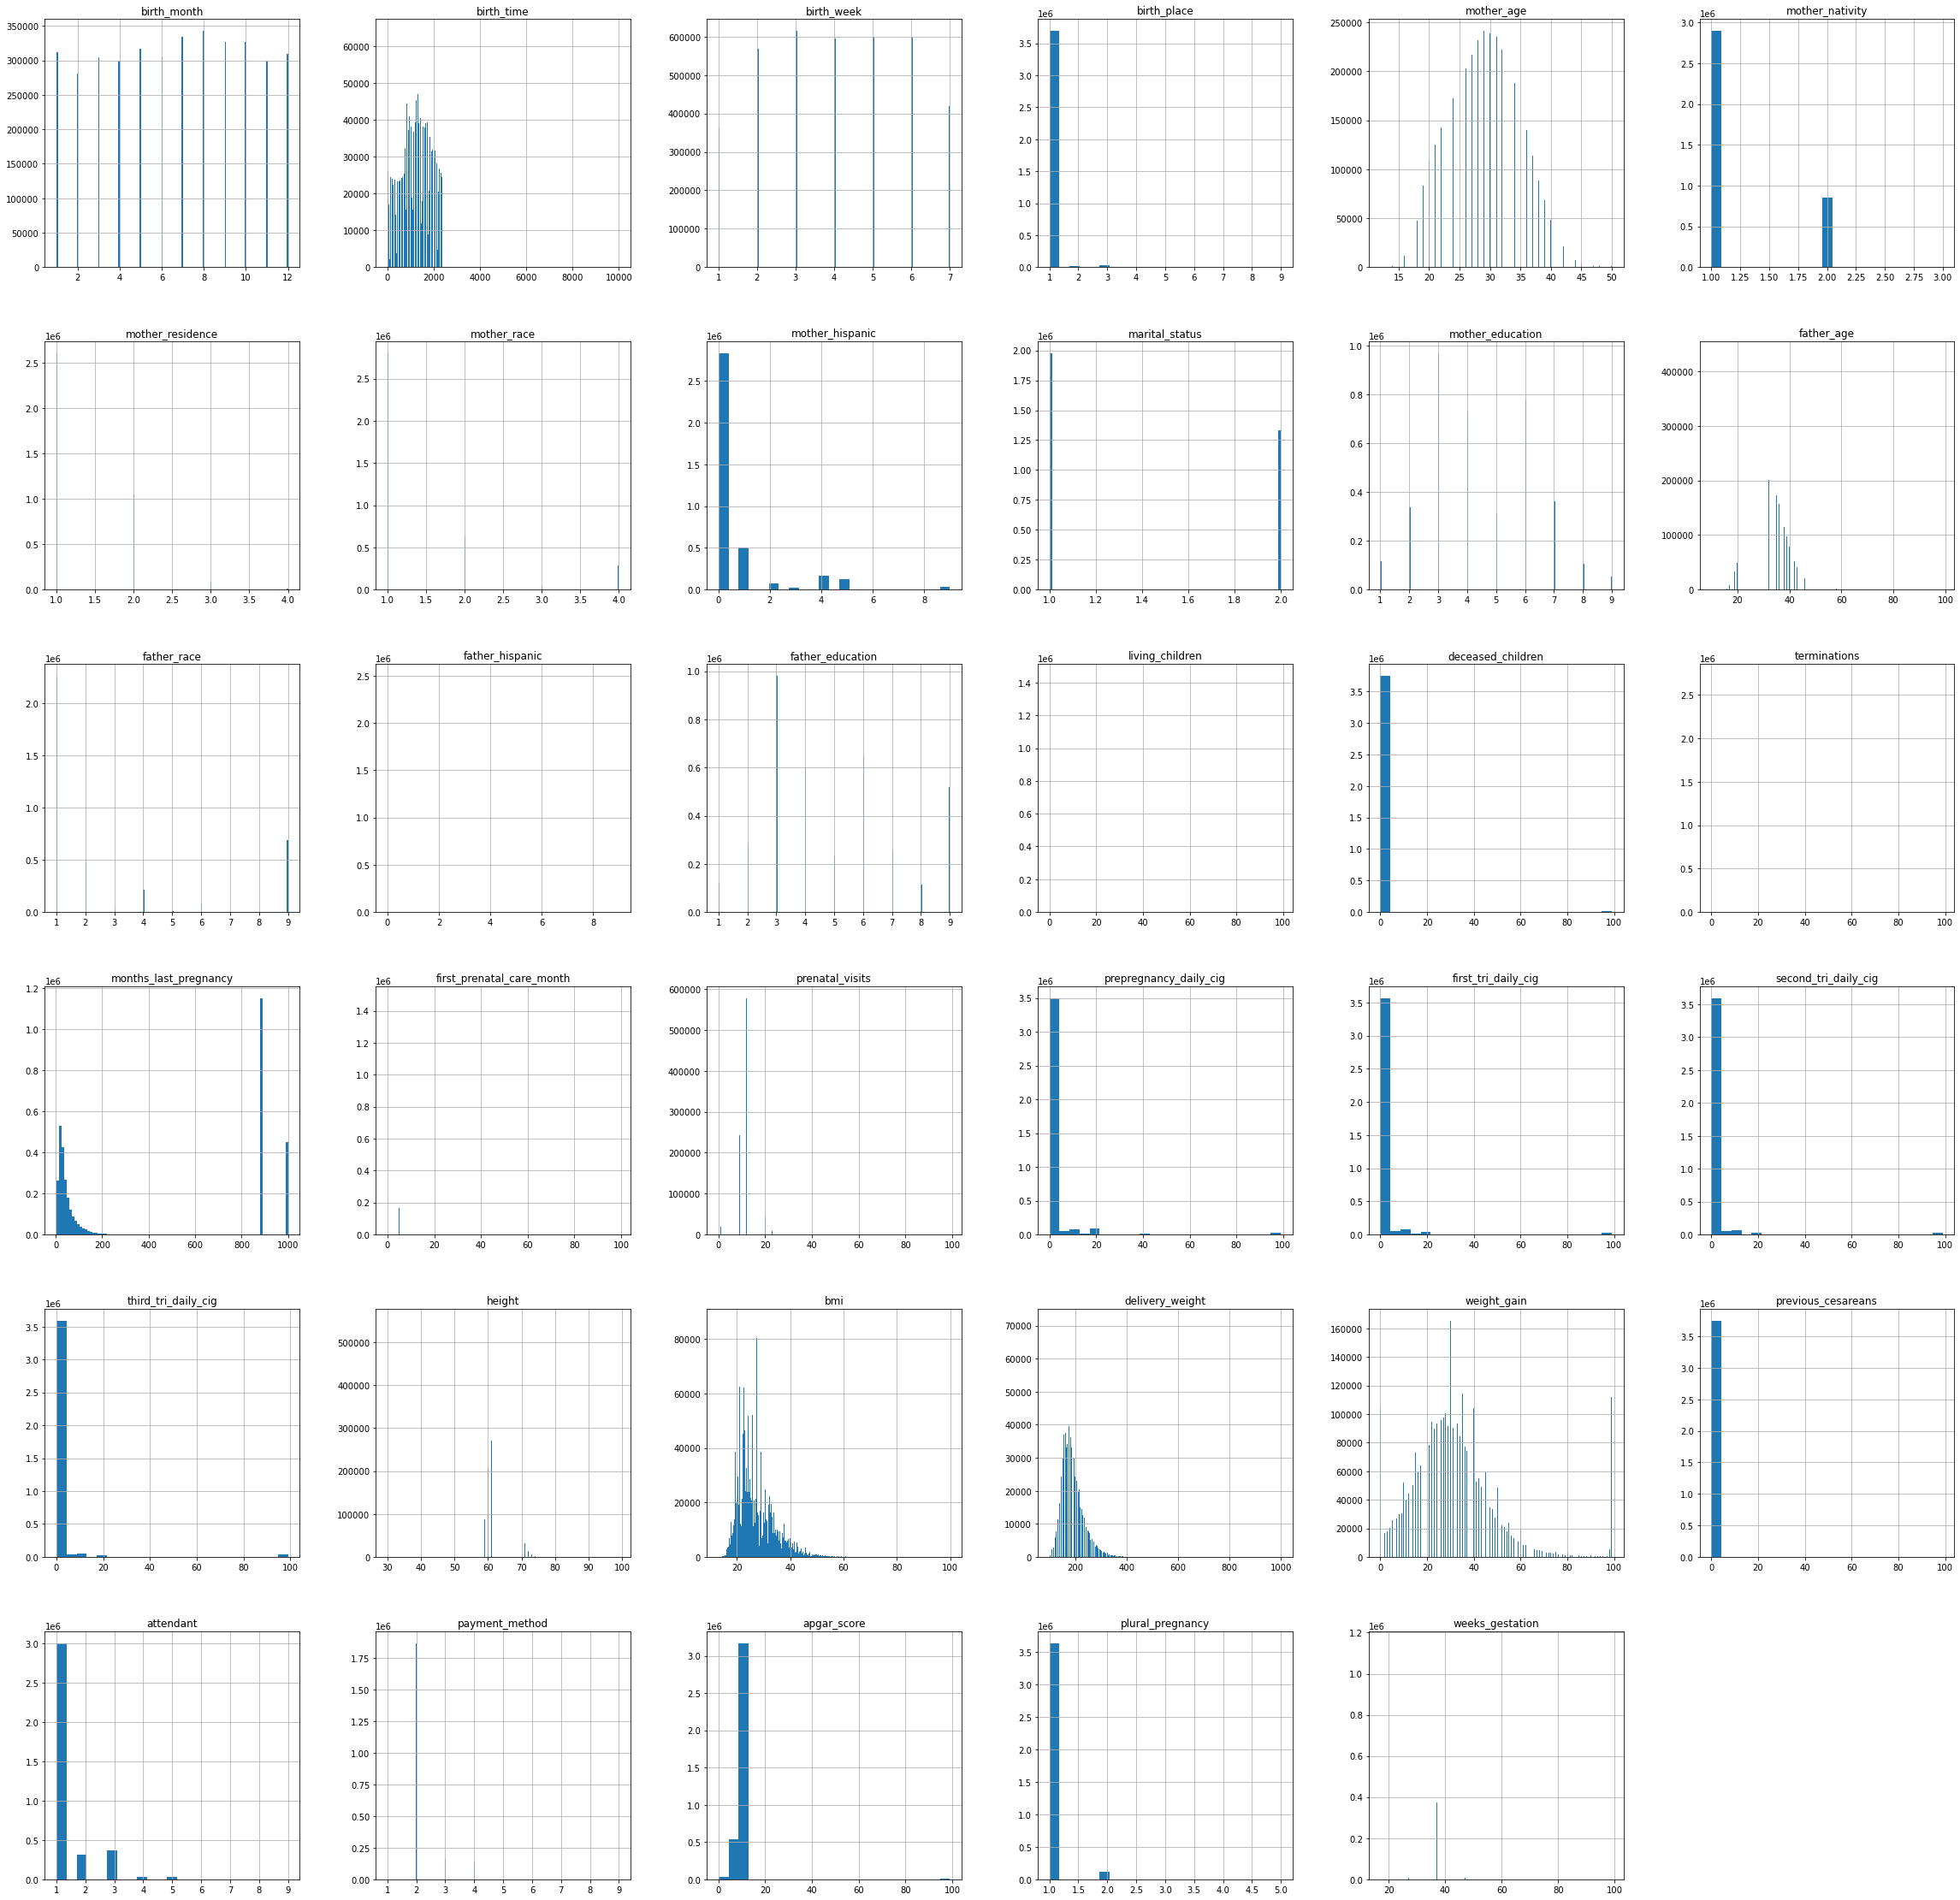

In [57]:
fig, axis = plt.subplots(figsize=(40, 40))
df.hist(ax=axis, bins='auto')